In [1]:
import vrplib

import copy
from types import SimpleNamespace

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.accept import HillClimbing
from alns.select import RouletteWheel
from alns.stop import MaxIterations

from thetisCVRPTW import *
from plotting import plot_solution, plot_data
from destroy import *
from repair import *

In [2]:
%matplotlib inline
SEED = 1234

# Capacitated Vehicle Routing Problem with Time Windows
Based on ALNS example of CVRP.

NOTE: needs implementation of pick-up and drop-off of customers

## Ideas for improvement

-   Change from native lists to numpy arrays

## Data
Description of datasets and BKS can be found here:

http://w.cba.neu.edu/~msolomon/problems.htm

In [3]:
data = vrplib.read_instance("data/r1/r101.txt", instance_format="solomon")
datac1 = vrplib.read_instance("data/c1/c101.txt", instance_format="solomon")

Depot location is the first location in node_coord, beacuse demand = 0

In [4]:
data['dimension'] = len(data['demand'])
print(data.keys())

dict_keys(['name', 'vehicles', 'capacity', 'node_coord', 'demand', 'time_window', 'service_time', 'edge_weight', 'dimension'])


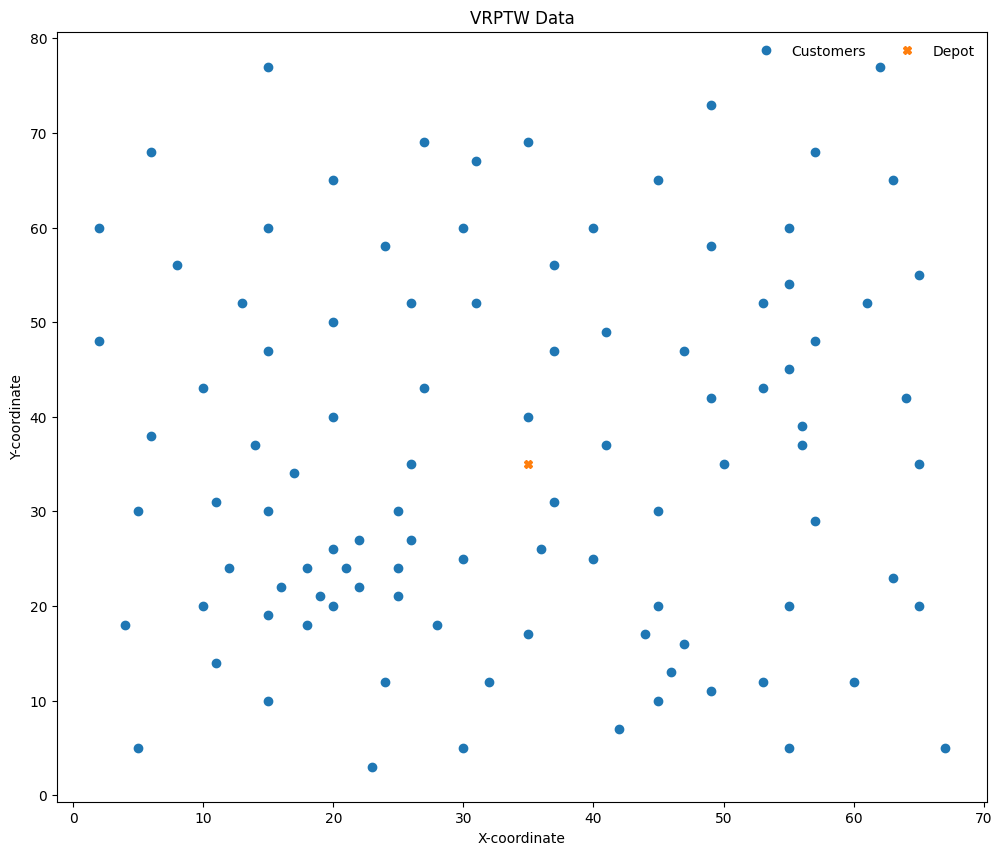

In [5]:
plot_data(data)

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [6]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 5 customers.


## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

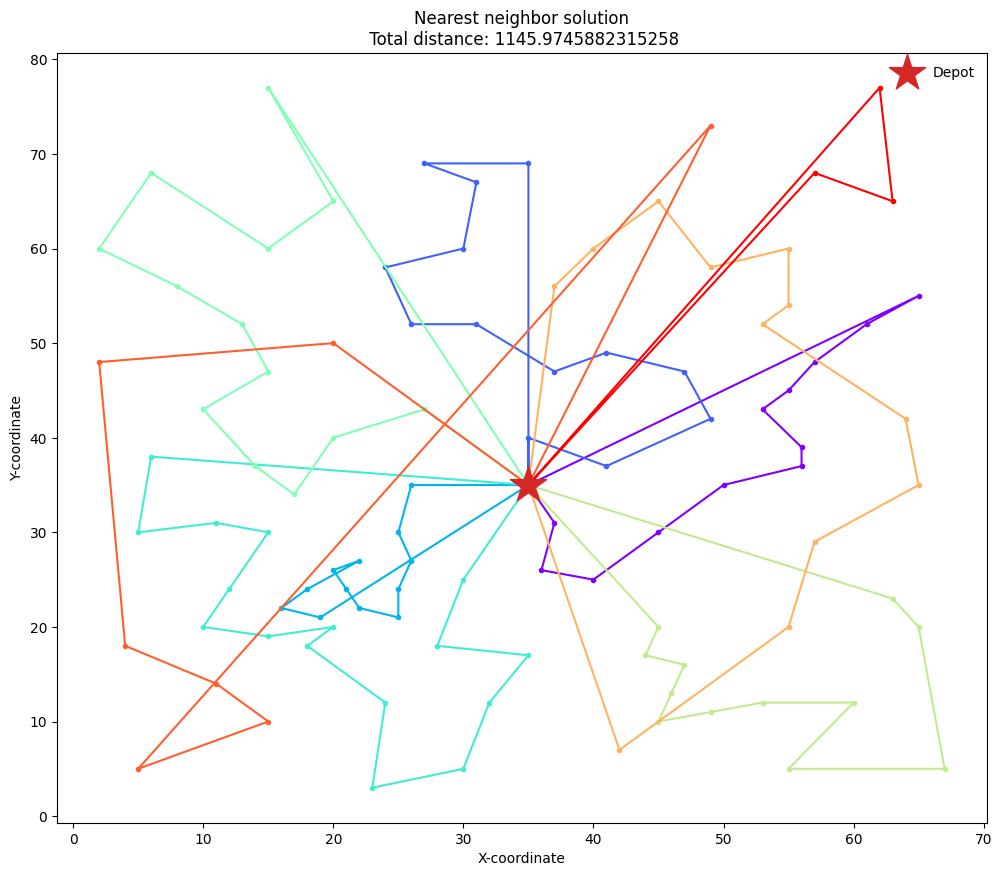

In [7]:
initial_solution = nearest_neighbor_tw(data)

plot_solution(data, initial_solution, "Nearest neighbor solution")

## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair operators. 

In [8]:
alns = ALNS(rnd.default_rng(SEED))

alns.add_destroy_operator(random_removal)

alns.add_repair_operator(greedy_repair)

In [9]:
num_iterations = 10000
init = nearest_neighbor_tw(data)
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(
    init.objective(data), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result = alns.iterate(data, init, select, accept, stop)

TypeError: ALNS.iterate() missing 1 required positional argument: 'stop'

In [ ]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [ ]:
plot_solution(solution, "Heuristic solution")

## Changing the accoeptance criterion to hill climbing

In [ ]:
num_iterations = 3000
init = nearest_neighbor_tw()
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = HillClimbing()
stop = MaxIterations(num_iterations)
result = alns.iterate(init, select, accept, stop)

In [ ]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

In [ ]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [ ]:
plot_solution(solution, "Heuristic solution")

## Checking the correctness of the solution

In [ ]:
help(solution)

In [ ]:
print(solution.times)

In [ ]:
print(solution.routes)

In [ ]:
data['edge_weight'][0][53]

In [ ]:
data["edge_weight"][53][58]